# PFL with Regret Minimization

## Simplified Algorithm 

Step 1: Initialize weights w.

Step 2: Randomly choose a set $i' = i_1, ..., i_B$ from the available clients.

Step 3: Use the local dataset $D_{i'}$ to perform a gradient descent step:
$ \tilde{w}^{(i, i')} = w^{(i)} - \alpha \nabla L_{i'}(w^{(i)}) $

Step 4: Compute rewards $r_{i,i'}$ for $i' = i_1, ..., i_B$ at each task.
$r_{i,i'} = L_{i}(w^{(i)}) - L_{i}(\tilde{w}^{(i, i')})$

Step 5: Use the gradient step for the local dataset i with the largest reward $r_{i,i'}$.

Step 6: If the stopping criterion is not met, continue with step 2.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import random
import math

In [2]:
class Client:
    def __init__(self, NUM_SAMPLES, num_features, weights, true_w, STD):
        self.weights = weights

        self.X, self.y = generate_data(NUM_SAMPLES, num_features,
                                       true_w, STD)
        self.GT_w = true_w

    def get_local_loss(self, weights):
        prediction = self.X @ weights
        loss_ = ((prediction - self.y) ** 2).mean()
        return loss_

    def train_locally(self, L, lr):
        weights = self.weights.clone()
        for l in range(0, L):
            weights.requires_grad_()
            weights.grad = None
            prediction = self.X @ weights
            loss_ = ((prediction - self.y) ** 2).mean()
            loss_.backward()
            grad = weights.grad.clone()
            with torch.no_grad():
                weights = weights - lr * grad
        self.weights = weights.detach()
        return weights.detach()

    def eval(self, weights):
        with torch.no_grad():
            return ((self.GT_w - weights).norm(p=2)).item()


In [3]:
def generate_data(NUM_SAMPLES, num_features, true_w, STD):
    """Generate synthetic data for a user."""
    X = torch.randn(NUM_SAMPLES, num_features, dtype=torch.float64)
    y = X @ true_w + STD * torch.randn(NUM_SAMPLES, 1)
    return X, y

### Getting Clients List

In [4]:
def get_clients_list(num_features):
    one_hotted_GT = torch.from_numpy(np.eye(NUM_CLUSTERS)[np.random.choice(NUM_CLUSTERS,
                                                                           NUM_CLIENTS)].T)  # creates a matrix and indicates which client belongs to which cluster it has k rows and n coloumns
    core_GT_weights = torch.from_numpy(np.random.uniform(low=-10, high=10, size=(num_features, NUM_CLUSTERS)))  # (d, k)
    w_init_mat = torch.randn(num_features, NUM_CLIENTS, requires_grad=False, dtype=torch.float64)

    clients_GT_weights = core_GT_weights @ one_hotted_GT  # (d, n) = (d, k) @ (k, n)
    clients_list = []


    for client_iter in range(NUM_CLIENTS):
        GT_w = clients_GT_weights[:, client_iter].reshape(-1, 1)
        w = w_init_mat[:, client_iter].reshape(-1, 1).clone()
        clients_list.append(Client(NUM_SAMPLES, num_features, w, GT_w, STD))
    return clients_list

## Finding  $\tilde{w}$ For Each Task

This section correspond to calculation of reward using `get_w_candidates` and `get_w_with_best_reward` functions. `get_w_candidates` computes $\tilde{w}^{(i, i')}$ for each task in the subset $i' \in \{i_1, ... i_B\}$, and `get_w_with_best_reward` calculates the rewards based on the difference in local loss when using these candidate weights and returns the $ \tilde{w}^{(i, i')}$ with the biggest reward.

In [5]:
def find_w_candidate(current_weight, X, y, lr):
    current_weight.requires_grad_()
    current_weight.grad = None
    prediction = X @ current_weight
    loss_ = ((prediction - y) ** 2).mean()
    loss_.backward()
    with torch.no_grad():
        w_candidate = current_weight - lr * current_weight.grad
    return w_candidate

In [6]:
def get_w_candidates(clients_list, curr_client_id, num_features, client_ids, lr):
    curr_weight = clients_list[curr_client_id].weights.clone()
    candidates = torch.zeros((num_features, SUBSET_SIZE), dtype=torch.float64)
    for iter_client in range(SUBSET_SIZE):
        id_ = client_ids[iter_client]
        client = clients_list[id_]
        w_iter = find_w_candidate(curr_weight.clone(), client.X, client.y, lr)
        candidates[:, iter_client] = w_iter.clone().squeeze()
    return candidates

In [7]:
def get_w_with_best_reward(num_features, candidates, client):
    current_loss = client.get_local_loss(client.weights)
    rewards = torch.empty((SUBSET_SIZE), dtype=torch.float64)
    for iter_client in range(SUBSET_SIZE):
        rewards[iter_client] = current_loss - client.get_local_loss(candidates[:, iter_client].reshape(num_features, 1))
    idx_max_reward = torch.argmax(rewards)
    return candidates[:, idx_max_reward]

#### Finding Subset of Tasks (Step 2)

In [8]:
def get_random_indices_without_i():
    indices = np.arange(0, NUM_CLIENTS)
    total_client_ids = np.empty((SUBSET_SIZE, NUM_CLIENTS), dtype=int)

    for iter_client in range(NUM_CLIENTS):
        available_indices = np.delete(indices, iter_client)
        random_indices = np.random.choice(available_indices, size=SUBSET_SIZE, replace=False)
        total_client_ids[:, iter_client] = random_indices
    return total_client_ids

## Implementing Algorithm

In [9]:
def algorithm(clients_list, num_features, num_rounds, lr):
    total_loss = []
    for round_ in range(num_rounds):
        total_subsets = get_random_indices_without_i()
        w_mat = torch.empty((num_features, NUM_CLIENTS), dtype=torch.float64)
        for iter_client in range(NUM_CLIENTS):
            curr_client_candidates = get_w_candidates(clients_list, iter_client, num_features,
                                                      total_subsets[:, iter_client], lr)
            w_mat[:, iter_client] = get_w_with_best_reward(num_features, curr_client_candidates,
                                                           clients_list[iter_client])
        loss = []
        
        for iter_client in range(NUM_CLIENTS):
            loss.append(clients_list[iter_client].eval(clients_list[iter_client].weights.detach()))
            clients_list[iter_client].weights = w_mat[:, iter_client].clone().reshape(-1, 1)
        total_loss.append(sum(loss)/len(loss))   
    return total_loss

## A Baseline: Training Independently

In [10]:
def train_seperately(clients_list, num_rounds, lr):
    list_loss_tot_ind = []
    for round_ in range(0, num_rounds):
        list_loss_ind = []
        for client_iter in range(0, NUM_CLIENTS):
            list_loss_ind.append(clients_list[client_iter].eval(clients_list[client_iter].weights.detach()))
#             list_loss_ind.append(clients_list[client_iter].get_local_loss(clients_list[client_iter].weights.detach()))

            clients_list[client_iter].train_locally(1,lr)
        list_loss_tot_ind.append(sum(list_loss_ind) / len(list_loss_ind))
    return list_loss_tot_ind

## All Pieces Together:

In [11]:
def main(lr, num_features):
    clients_ls = get_clients_list(num_features)
    return algorithm(clients_ls, num_features, NUM_ROUNDS, lr)

In [12]:
NUM_SAMPLES = 10
dm = 10
n_features = int(NUM_SAMPLES * dm) 
STD = 0.01
NUM_CLUSTERS = 2
NUM_CLIENTS = 100
SUBSET_SIZE = 10
NUM_ROUNDS = 2000
learning_rate = 0.01

In [13]:
subset_sizes = [2, 4, 8, 14, 20, 50]
total_losses = []
for SUBSET_SIZE in subset_sizes:
    total_losses.append(main(learning_rate, n_features))

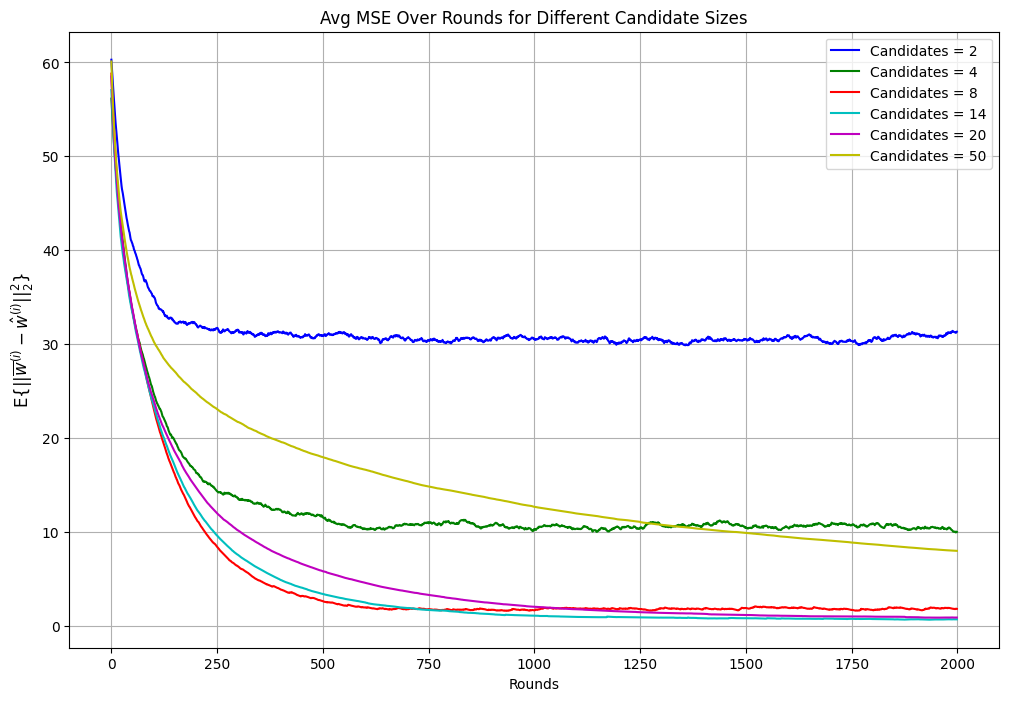

In [14]:
color_palette = ['b', 'g', 'r', 'c', 'm', 'y']

x = np.arange(NUM_ROUNDS)
m = len(total_losses)
fig = plt.figure(figsize=(12, 8))

for i in range(m):
    plt.plot(x, total_losses[i], label=f"Candidates = {subset_sizes[i]}", color=color_palette[i % len(color_palette)])

plt.legend()
plt.xlabel("Rounds")
plt.ylabel("E{${||\overline{w}^{(i)} - \hat{w}^{(i)} ||^2_2} $}", fontsize=12)
plt.title("Avg MSE Over Rounds for Different Candidate Sizes")
plt.grid(True)  #
plt.show()

In [15]:
print(3)

3
